# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [1]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

## Solution
---
##### Assumption : For this exercise, we assume that when there is no value in a field, it does not mean 0, it means that we don't know the value. Thus, for the daily average per month, we do this average using existing data.

Useful columns :

* For Guinea : <br />
 new cases : 'total new cases registered so far' <br />
 deaths : 'new deaths registered', 'new deaths registered today'

* For Liberia : <br />
new cases : 'new case/s (suspected)', 'new case/s (probable)', 'new case/s (confirmed)' <br />
deaths : 'newly reported deaths' <br />
December -> <br />
new cases : 'cumulative confirmed, probable and suspected cases' <br />
deaths : 'total death/s in confirmed, \n probable, suspected cases'

* For Sierra Leone : <br />
new cases : 'new_noncase', 'new_suspected', 'new_probable', 'new_confirmed'<br />
deaths : 'etc_new_deaths'

First of all, we need to read all of the data which is in the csv format. So for this, we need to retrieve all csv file names for some country. 
Thus using a ls command seems to be the best option here. After that, we retrieve and concatenate the csv files.
We then filter the rows by their description, looking for the new cases and deaths related descriptions. 

Right after, we rename these descriptions to be either 'New cases' or 'Deaths'.
There may be multiple 'New cases' or 'Deaths' possibilities for each date, however, as we will see, we deal with them using groupby operations.

We then recompute the total using the results per county, as sometimes the total is not defined even if some county have some values. We assign the result to the total field when it's not defined. And for rows where there are less than 3 values defined, which are the Date, the Descripton and the total (or some county values that are used to recompute the total), we drop them.

After that we can group_by the month, the day and the description, to obtain at most one result per (day, 'New cases'), and at most one result per (day, 'Deaths'). 

After that, we can do the daily average per month, by doing a groupby over the first and third index columns (month and description), and a mean of each bucket. We rename the indexes and the column.
We do this procedure for each country, with different column names, 'New cases' and 'Deaths' descriptions, and when we have the three DataFrames, we concatenate them.

However, it's not that easy for the whole data : in fact for Liberia, in the month of december the data was entered incorrectly. The data given in the Description fields 'new case/s (suspected)', 'new case/s (probable)' and 'new case/s (confirmed)' is cumulative, compared to before when it was the result of the day. Fortunately, as for this month we have continuous days : from day 1 to day 9 without gap, we can infer the missing data by using the cumulative cases and deaths fields in Description : 'cumulative confirmed, probable and suspected cases' and 'total death/s in confirmed, \n probable, suspected cases'. By using the 2014-11-30 day as a starting point, we can create the New cases and Deaths data we wanted. We do it in the country_DF_cumulative function.

Because of this, we need to specify to the country_DF_mass function (working with non-cumulative fields) that liberia will not need to work with all csv files, as the december subpart is already used in the other method. The lsnames field is there for that.




Question : in the case

* 0 	2014-10-01 	New cases of suspects 	28
* 1 	2014-10-01 	New cases of probables 	0
* 2 	2014-10-01 	New cases of confirmed 	6
* 3 	2014-10-01 	Total new cases registered so far 	34
* 15 	2014-10-01 	New cases of confirmed among health workers 	2

Do we count the New cases of confirmed among health workers as part of New cases of confirmed, so that the total is correct, or is it a new category ?

In [234]:
def get_filenames(path):
    filenames = !ls $path
    return filenames

def get_cols(df, to_remove):
    cols = pd.Series(df.columns)
    return cols[~cols.isin(to_remove)]

def country_DF_mass(country, date_c, description_c, total_c, filters_new_cases, filters_deaths, lsnames=''):
    
    PATH = ''
    
    if(not lsnames):
        PATH = DATA_FOLDER + '/ebola/' + country + '_data/'
        country_files = get_filenames(PATH)
    else:
        country_files = lsnames

    country_DF = pd.concat([pd.read_csv(PATH+filename, parse_dates=[date_c], na_values=['-']) 
                           for filename in country_files]) 

    country_DF = country_DF.loc[[ description.lower() in filters_new_cases or
                                    description.lower() in filters_deaths
                                    for description in country_DF[description_c].values]]
    
    country_DF.loc[[description.lower() in filters_new_cases for description in country_DF[description_c]], description_c] = 'New cases'
    country_DF.loc[[description.lower() in filters_deaths for description in country_DF[description_c]], description_c] = 'Deaths'
    
    cols = get_cols(country_DF, to_remove=[date_c, description_c, total_c])
    
    country_DF = country_DF.dropna(thresh = 3) #drop every entry containing no data, as we can't infer anything (it's not 0)
    recomputed_total = country_DF[cols].apply(pd.to_numeric).sum(axis=1)

    country_DF[total_c] = pd.to_numeric(country_DF[total_c]).combine_first(recomputed_total)
    
    country_computation = pd.DataFrame(country_DF.groupby([country_DF[date_c].dt.month, country_DF[date_c].dt.day, country_DF[description_c]])[total_c].sum())
    country_computation = country_computation.groupby(level=[0,2]).mean()
    country_computation.index.names = ['Month', 'Description']
    country_computation.columns = ['Daily average per month']
    return country_computation


def country_DF_cumulative(country, date_c, description_c, total_c, filters_new_cases, filters_deaths, date_begin= '2014-11-30', date_end='2014-12-09'):
    """To use this function, the data must be in following days, => no gap"""
    PATH = DATA_FOLDER + '/ebola/' + country + '_data/'
    
    country_DF = pd.concat([pd.read_csv(PATH + date_begin + '.csv', parse_dates=[date_c], na_values=['-']), 
                            pd.read_csv(PATH + date_end + '.csv', parse_dates=[date_c], na_values=['-'])]) 
    
    country_DF = country_DF.loc[[ description.lower() in filters_new_cases or
                                    description.lower() in filters_deaths
                                    for description in country_DF[description_c].values]]
    
    cols = get_cols(country_DF, to_remove=[date_c, description_c, total_c])
    recomputed_total = country_DF[cols].apply(pd.to_numeric).sum(axis=1)
    country_DF[total_c] = pd.to_numeric(country_DF[total_c]).combine_first(recomputed_total)
    
    country_DF.loc[[description.lower() in filters_new_cases for description in country_DF[description_c]], description_c] = 'New cases'
    country_DF.loc[[description.lower() in filters_deaths for description in country_DF[description_c]], description_c] = 'Deaths'
    
    days_between = (pd.to_datetime(date_end) - pd.to_datetime(date_begin)).days
    
    country_DF = country_DF.groupby(country_DF[description_c])[total_c].apply(lambda x: x.iloc[1] - x.iloc[0])/days_between
    country_DF = pd.DataFrame(pd.concat({pd.to_datetime(date_end).month: country_DF}))
    country_DF.index.names = ['Month', 'Description']
    country_DF.columns = ['Daily average per month']
    
    return country_DF


guinea = country_DF_mass('guinea', 'Date', 'Description', 'Totals', ['total new cases registered so far'], ['new deaths registered', 'new deaths registered today'])

liberia_mass_files = !ls 'Data/ebola/liberia_data'/2014-[0.1][^2]*
liberia = country_DF_mass('liberia', 'Date', 'Variable', 'National', ['new case/s (suspected)', 'new case/s (probable)', 'new case/s (confirmed)'], ['newly reported deaths'], liberia_mass_files)
liberia_december = country_DF_cumulative('liberia', 'Date', 'Variable', 'National', ['cumulative confirmed, probable and suspected cases'], ['total death/s in confirmed, \n probable, suspected cases'])
liberia = pd.concat([liberia, liberia_december])

sl = country_DF_mass('sl', 'date', 'variable', 'National', ['new_noncase', 'new_suspected', 'new_probable', 'new_confirmed'], ['etc_new_deaths'])

pd.concat({'Guinea': guinea, 'Liberia': liberia, 'Sierra Leone': sl})

Daily average per month
             Month Description                         
Guinea       8     Deaths                      3.400000
                   New cases                  25.800000
             9     Deaths                      3.562500
                   New cases                  19.625000
             10    Deaths                     15.000000
                   New cases                  34.000000
Liberia      6     Deaths                      2.000000
                   New cases                   5.714286
             7     Deaths                      4.272727
                   New cases                   8.545455
             8     Deaths                     23.222222
                   New cases                  37.222222
             9     Deaths                     37.608696
                   New cases                  63.833333
             10    Deaths                     28.040000
                   New cases                  45.560000
             11    Deaths                     15.538462
                   New cases                  30.266667
             12    Deaths                     14.777778
                   New cases                  16.000000
Sierra Leone 8     Deaths                      5.550000
                   New cases                  38.350000
             9     Deaths                      4.571429
                   New cases                  71.620690
             10    Deaths                      4.952381
                   New cases                 124.214286
             11    Deaths                      2.000000
                   New cases                 172.578947
             12    Deaths                      5.500000
                   New cases                 226.333333

In [295]:
"""
def country_DF(country, date_c, description_c, total_c, filters_new_cases, filters_deaths):
    path = DATA_FOLDER + '/ebola/' + country + '_data/'
    country_files = !ls $path

    country_DF = pd.concat([pd.read_csv(path+filename, usecols=[date_c, description_c, total_c], parse_dates=[date_c], index_col=False) 
                           for filename in country_files]) 
    

    country_DF = country_DF.loc[[ description.lower() in filters_new_cases or
                                    description.lower() in filters_deaths
                                    for description in country_DF[description_c].values]]

    country_DF.loc[[description.lower() in filters_new_cases for description in country_DF[description_c]], description_c] = 'New cases'
    country_DF.loc[[description.lower() in filters_deaths for description in country_DF[description_c]], description_c] = 'Deaths'
    country_DF[total_c] = pd.to_numeric(country_DF[total_c])
    

    country_computation = pd.DataFrame(country_DF.groupby([country_DF[date_c].dt.month, country_DF[date_c].dt.day, country_DF[description_c]])[total_c].sum())
    country_computation = country_computation.groupby(level=[0,2]).mean()
    country_computation.index.names = ['Month', 'Description']
    country_computation.columns = ['Daily average per month']
    return country_computation

guinea = country_DF('guinea', 'Date', 'Description', 'Totals', ['total new cases registered so far'], ['new deaths registered', 'new deaths registered today'])
liberia = country_DF('liberia', 'Date', 'Variable', 'National', ['new case/s (suspected)', 'new case/s (probable)', 'new case/s (confirmed)'], ['newly reported deaths'])
sl = country_DF('sl', 'date', 'variable', 'National', ['new_noncase', 'new_suspected', 'new_probable', 'new_confirmed'], ['death_suspected', 'death_probable', 'death_confirmed'])

pd.concat({'Guinea': guinea, 'Liberia': liberia, 'Sierra Leone': sl})
"""
pass

In [294]:
"""
def country_DF(country, date_c, description_c, total_c, filters_new_cases, filters_deaths):
    path = DATA_FOLDER + '/ebola/' + country + '_data/'
    country_files = !ls $path

    country_DF = pd.concat([pd.read_csv(path+filename, parse_dates=[date_c], na_values=['-']) 
                           for filename in country_files]) 

    country_DF = country_DF.loc[[ description.lower() in filters_new_cases or
                                    description.lower() in filters_deaths
                                    for description in country_DF[description_c].values]]
    
    cols = pd.Series(country_DF.columns)
    cols = cols[~cols.isin([date_c, description_c, total_c])]
    
    #print(country_DF.dropna(thresh = 3))
    #print('-'*200)
    country_DF = country_DF.dropna(thresh = 3) #drop every entry containing no data, as we can't infer anything (it's not 0)
    recomputed_total = country_DF[cols].apply(pd.to_numeric).sum(axis=1)
    
    #tmp = pd.DataFrame()
    #tmp["recomputed"] = recomputed_total
    #tmp["total"] = pd.to_numeric(country_DF[total_c])
    #tmp["combined"] = pd.to_numeric(country_DF[total_c]).combine_first(recomputed_total)
    #print(tmp)
    
    country_DF[total_c] = pd.to_numeric(country_DF[total_c]).combine_first(recomputed_total)
    #print(country_DF[[date_c, description_c, total_c]])

    country_DF.loc[[description.lower() in filters_new_cases for description in country_DF[description_c]], description_c] = 'New cases'
    country_DF.loc[[description.lower() in filters_deaths for description in country_DF[description_c]], description_c] = 'Deaths'
    #country_DF[total_c] = pd.to_numeric(country_DF[total_c])
    
    
    country_computation = pd.DataFrame(country_DF.groupby([country_DF[date_c].dt.month, country_DF[date_c].dt.day, country_DF[description_c]])[total_c].sum())
    country_computation = country_computation.groupby(level=[0,2]).mean()
    country_computation.index.names = ['Month', 'Description']
    country_computation.columns = ['Daily average per month']
    return country_computation

guinea = country_DF('guinea', 'Date', 'Description', 'Totals', ['total new cases registered so far'], ['new deaths registered', 'new deaths registered today'])
liberia = country_DF('liberia', 'Date', 'Variable', 'National', ['new case/s (suspected)', 'new case/s (probable)', 'new case/s (confirmed)'], ['newly reported deaths'])
sl = country_DF('sl', 'date', 'variable', 'National', ['new_noncase', 'new_suspected', 'new_probable', 'new_confirmed'], ['etc_new_deaths'])

pd.concat({'Guinea': guinea, 'Liberia': liberia, 'Sierra Leone': sl})
"""
pass

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

## Solution
---
First of all, I query the microbiome file names, using ls. I remove the extension part.
Then, I read the xls files and convert it to a DataFrame, and I put an additional column (BARCODE), corresponding to the file name, with the same value for the whole DataFrame.
I concatenate those DataFrames into one and I put the index (Phylum) as a column.
I can now do an inner join between the big DataFrame and the metadata DataFrame, on the BARCODE column. I set the index ('Phylum', 'BARCODE'), as it's unique. And I can replace all occurences of NaN by 'unknown', as requested in the statement.

In [216]:
PATH = DATA_FOLDER + '/microbiome/'
files = !cd $PATH; ls MI*
filenames = map(lambda file: file[:file.find('.')], files)

rna = pd.concat([pd.read_excel(PATH + filename + '.xls', sheetname=0, header=None, names= ["Counts"], index_col=0)
                 .assign(BARCODE=filename) for filename in filenames])
rna['Phylum'] = rna.index.values

metadata = pd.read_excel(DATA_FOLDER + '/microbiome/metadata.xls')

merged = pd.merge(rna, metadata, on='BARCODE').set_index(['Phylum', 'BARCODE'])
merged = merged.replace(np.nan, 'unknown')

#print(merged.index.is_unique) #prints True
#print(merged.isnull().values.any()) #prints False
merged

,,Counts,GROUP,SAMPLE
Phylum,BARCODE,,,
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",MID1,7,EXTRACTION CONTROL,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrolobus",MID1,2,EXTRACTION CONTROL,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Sulfolobales Sulfolobaceae Stygiolobus",MID1,3,EXTRACTION CONTROL,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Thermoproteales Thermofilaceae Thermofilum",MID1,3,EXTRACTION CONTROL,unknown
"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Methanocellales Methanocellaceae Methanocella",MID1,7,EXTRACTION CONTROL,unknown
"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Methanosarcinales Methanosarcinaceae Methanimicrococcus",MID1,1,EXTRACTION CONTROL,unknown
"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Methanosarcinales Methermicoccaceae Methermicoccus",MID1,1,EXTRACTION CONTROL,unknown
"Archaea ""Euryarchaeota"" Archaeoglobi Archaeoglobales Archaeoglobaceae Ferroglobus",MID1,1,EXTRACTION CONTROL,unknown
"Archaea ""Euryarchaeota"" Archaeoglobi Archaeoglobales Archaeoglobaceae Geoglobus",MID1,1,EXTRACTION CONTROL,unknown


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [217]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

## Solution
---
1. For each attribute, I seek to use the describe() method on it, to understand how the data behaves, I use the unique() method to understand the range of it, and I check information provided in the Data frame. I also check if there are NaN values for this attribute.<br /><br />
pclass is an integer which can take the values 1, 2 or 3, and no NaN values. We convert it to a category ['1st', '2nd', '3rd']. <br /><br />
survived is an integer which can take the values 0 or 1, and no NaN values. We convert it to a category ['no', 'yes']. <br /><br />
name is a character string, which can take a variable number of characters between 12 ('Lam, Mr. Ali') and 82 ('Penasco y Castellana, Mrs. Victor de Satode (Maria Josefa Perez de Soto y Vallejo)'), and no NaN values. There are names duplicates : The name 'Connolly, Miss. Kate' corresponds to 2 different people. We don't use a category. <br /><br />
sex is a character string, in the range ['female', 'male'], without NaN values. We convert it to a category ['female', 'male'].<br /><br />
age is a double value, which can take values between 0.1667 ('Dean, Miss. Elizabeth Gladys "Millvina"') and 80.0 ('Barkworth, Mr. Algernon Henry Wilson'). We don't use a category.<br /><br />
sibsp is a double that can take values [0, 1, 2, 3, 4, 5, 8], and no NaN values. There is no need to transform it to a category.<br /><br />
parch is an integer that can take values [0, 1, 2, 3, 4, 5, 6, 9], and no NaN values. There is no need to transform it to a category.<br /><br />
ticket is a character string (object in the data) that can take a variable number of characters between 3 ('680') and 18 ('SOTON/O.Q. 3101315'). There are ticket duplicates : 'CA. 2343'. We transform it to a category.<br /><br />
fare is a double that can take values between 0.0 and 512.3292, with some NaN values. We transform it to a category.<br /><br />
cabin is a character string that can have between 1 character ('D') and 15 characters ('B57 B59 B63 B66'), and it can also be a NaN value. We transform it to a category.<br /><br />
embarked is a character that can be in the range ['S', 'C', 'Q'], and can be a NaN value. We transform it to a category.<br /><br />
boat is an character string that can take values between 1 character ('D') and 7 characters ('13 15 B'). It can take NaN values. We transform it to a category.<br /><br />
boat is an integer value that can be between 1 and 328. It can also be NaN. We don't transform it to a category.<br /><br />
home.dest is a character string varying between 5 characters ('Paris') and 50 characters ('London, England / Marietta, Ohio and Milwaukee, WI'). There are NaN values. We transform it to a category.






In [428]:
titanic = pd.read_excel(DATA_FOLDER+'/titanic.xls', header=0)

titanic['pclass'] = titanic.pclass.astype('category')
titanic.pclass.cat.categories = ['1st', '2nd', '3rd']

titanic['survived'] = titanic.survived.astype('category')
titanic.survived.cat.categories = ['no', 'yes']

titanic['sex'] = titanic.sex.astype('category')

titanic['ticket'] = titanic.ticket.astype('category')

titanic['fare'] = titanic.fare.astype('category')

titanic['cabin'] = titanic.cabin.astype('category')

titanic['embarked'] = titanic.embarked.astype('category')

titanic['boat'] = titanic.boat.astype('category')

titanic['home.dest'] = titanic['home.dest'].astype('category')

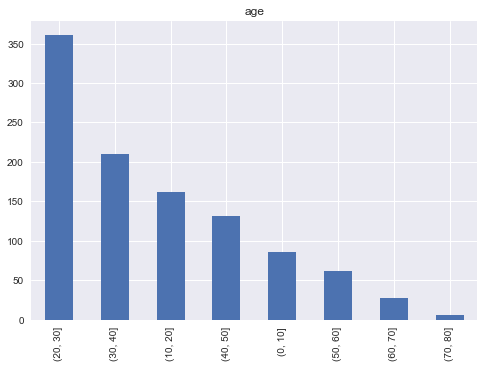

In [516]:
age_categories = [0,10,20,30,40,50,60,70,80]
age_cut = pd.cut(titanic.age, age_categories, )
ages = age_cut.value_counts()

ages.plot(kind='bar', subplots=True)
plt.show()